# Bankrupy Prediction Project


You will demonstrate your ability to solve a classification task.

The notebook that you submit *should follow the Recipe for Machine Learning* in addition to answering the questions.

# Objectives

For the student to demonstrate mastery on solving a classification problem and presenting
the entire Recipe for Machine Learning process in a notebook.

There will be little explicit direction for this task.

It is meant to be analagous to a pre-interview task that a potential employer might assign
to verify your skill

# Submission guidelines

**In addition** to showing your mastery, there is one task you must perform to make grading easier.

- You will implement the body of a subroutine `MyModel`
    - that takes as argument, the name of a CSV file containing the test set
    - performs predictions on each example in the test set
    - returns an array or predictions with a one-to-one correspondence with the examples in the test set
    
- You will call the subroutine, passing the name of the test set file that we will supply.

In this way, we can get the results of your model by executing a single cell.

`MyModel` has one *required* parameter: `fileName`
- you may add additional parameters as you need

`MyModel` is where you will perform whatever pre-processing you require, for example
- imputing missing values
- transformations
- whatever else you need


Here is the cell **that must appear as the last cell in your notebook**

In [1]:
TEST_PATH = "./data"

import pandas as pd
import os

testFileName = os.path.join(TEST_PATH, "test.csv")

def MyModel(fileName=None):
    print("Test file: ", fileName)
    
    # It should create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    
    # YOUR CODE GOES HERE
    
    
    return predictions

predicts = MyModel(fileName=testFileName)


Test file:  ./data/midterm_project\test.csv


# The problem

You are to predict whether a company will go bankrupt in the following year, based on financial attributes of the company.
- Each row of data corresponds to a single company
- There are 64 attributes, described in the section below
- The last column (`Bankrupt`) is 1 if the company subsequently went bankrupt; 0 if it did not go bankrupt
- The first column is a Company Identifier

# The Data

Here's the code to get the data.

In [2]:
import pandas as pd
import os

# Note the use of *relative path*; your assignments should all use relative rather than absolute paths
DATA_PATH = "./data"

data = pd.read_csv( os.path.join(DATA_PATH, "bankruptcy_data.csv") )


## Description of attributes

# Extra credit opportunities
- Address the issue of: classes being imbalanced
- Address the issue of: Different importance of each type of misclassification
    - It is 5 times worse to misclassify a company that *does go bankrupt* than to misclassify a company that does not go bankrupt
        - Suppose we invest in a company for which we predict it will not go bankrupt
            - We incur substantial losses for a bad investment
        - The loss from not investing in a company that we incorrectly classify as going bankrupt is small (opportunity cost)

# Here is my solution

In [3]:
import pandas as pd
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model, decomposition, datasets

warnings.filterwarnings('ignore')
%matplotlib inline

# Note the use of *relative path*; your assignments should all use relative rather than absolute paths
DATA_PATH = "./data"

data= pd.read_csv( os.path.join(DATA_PATH, "bankruptcy_data.csv") )

## A glance of the data set

we can see that there are some '?' and some 0 value in the data set

Now, we think that the 0 value is meaning nan value since all the factors are ratio of financial statement, it  is unlikely
to be 0

Here in the second step, we will count the nan value to prove it

In [4]:
data.sample(10, random_state=42)

,Id,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X56,X57,X58,X59,X60,X61,X62,X63,X64,Bankrupt
1749,5060,0.058754,0.11628,0.88372,8.6,302.12,-0.038405,0.065615,7.6,1.1377,...,0.070335,0.066485,0.94262,0,?,252.72,37.306,9.7839,?,0
2053,4015,-0.046153,0.46383,-0.2648,0.39035,-232.18,0,-0.041039,1.156,0.57357,...,0.001678,-0.086079,1.07120,0.000377,11.917,4.8459,276.400,1.3205,0.69067,0
538,2792,0.24304,0.39918,0.39097,2.2253,-1.9911,0,0.24304,1.5052,1.4314,...,0.255220,0.40452,0.75516,0,3.6421,10.666,81.361,4.4862,4.9364,0
438,3252,0.29175,0,0.90259,?,37.089,-0.30642,0.36006,?,8.8885,...,0.004776,0.29175,0.96089,0,?,21.597,0.000,?,91.252,0
2685,3642,0.12366,0.10538,0.58182,6.5212,96.659,0.35072,0.1544,5.8605,1.0769,...,0.071375,0.20023,0.92862,0,30.12,12.81,20.083,18.174,6.1227,0
402,2674,-0.12909,0.82743,-0.27977,0.66086,-144.62,-0.45178,-0.14507,0.050358,0.91908,...,-0.088040,-3.0981,1.08800,0.059659,4.4371,6.4294,214.730,1.6998,3.0831,0
1027,18,0.081442,0.70127,0.38696,1.6555,38.305,0,0.1029,0.42599,1.9797,...,0.062960,0.27262,0.94841,0,10.464,5.9258,108.850,3.3534,87.295,0
308,4387,-0.017269,0.6195,-0.031699,0.89704,2497.1,-0.000208,-0.01744,0.6142,0.67486,...,0.278340,-0.045385,0.76063,0.55863,5.4345,5.2509,166.510,2.192,0.93235,0
2439,3818,0.24562,0.66097,0.39833,2.1664,74.703,0,0.24562,0.51293,1.4282,...,0.190400,0.72448,0.83413,0.83655,9.1092,10.787,87.275,4.1822,5.4897,0
149,727,0.017231,0.88978,-0.069604,0.92011,-89.359,0.041832,0.015158,0.11715,1.0696,...,0.065042,0.16531,0.93496,0.17785,5.5594,3.6538,196.560,1.8569,8.156,0


In [5]:
# We see that there are some value 0 and we guess that the missing value is presented by 0
# Then we check if there are any null value

print('Some of Null Values in all colums = ', data.isna().sum().sum())

Some of Null Values in all colums =  0


We now see that the data 0 is indeed a sample of nan since there is not any nan value

Then, we will look at the data set more deeply

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4076 entries, 0 to 4075
Data columns (total 66 columns):
Id          4076 non-null int64
X1          4076 non-null object
X2          4076 non-null object
X3          4076 non-null object
X4          4076 non-null object
X5          4076 non-null object
X6          4076 non-null object
X7          4076 non-null object
X8          4076 non-null object
X9          4076 non-null object
X10         4076 non-null object
X11         4076 non-null object
X12         4076 non-null object
X13         4076 non-null float64
X14         4076 non-null object
X15         4076 non-null object
X16         4076 non-null object
X17         4076 non-null object
X18         4076 non-null object
X19         4076 non-null float64
X20         4076 non-null float64
X21         4076 non-null object
X22         4076 non-null object
X23         4076 non-null float64
X24         4076 non-null object
X25         4076 non-null object
X26         4076 non-null object

## Checking the data again

We now find that the data is obj and we need to change it into number and deal with the '?'

In [7]:
# Clean data: to show missing data as NaN
def CleanOne(data):
    data = data.apply(pd.to_numeric, errors='coerce')
    cols = [i for i in data.columns if i not in ['Bankrupt', 'Id']]
    data[cols] = data[cols].replace(0, np.nan)
    #print('null values:\n', data.isna().sum())
    return data
data = CleanOne(data)

In [8]:
print(data.describe())
print(data.shape)

                Id           X1           X2           X3           X4  \
count  4076.000000  4046.000000  4058.000000  4071.000000  4057.000000   
mean   3022.267910    -0.091505     0.574095     0.167326     4.300340   
std    1742.080279     7.323650     1.551269     1.455501    26.970635   
min       0.000000  -463.890000     0.000342   -72.067000    -0.403110   
25%    1500.000000     0.003937     0.254848     0.037722     1.079000   
50%    2998.000000     0.048327     0.456560     0.218890     1.640100   
75%    4542.000000     0.117600     0.669898     0.420430     2.985900   
max    5909.000000     5.530000    72.416000    28.336000   788.090000   

                 X5           X6           X7           X8           X9  ...  \
count  4.067000e+03  2501.000000  4067.000000  4058.000000  4075.000000  ...   
mean  -2.653959e+02    -0.291890    -0.077971     5.690827     1.603746  ...   
std    1.695217e+04    10.804478     7.305424    66.706935     1.583191  ...   
min   -1.0764

It is reasonable to check if the data is banlance or not since not so many company bankrupt

And we will find that it is very imbanlance

In [9]:
num_bankrupt = data['Bankrupt'].sum()
percantage_bankrupt = num_bankrupt / data.shape[0]
print("The number of default is {0} and the percentage of default is {1}".format(num_bankrupt, percantage_bankrupt))

The number of default is 410 and the percentage of default is 0.10058881256133465


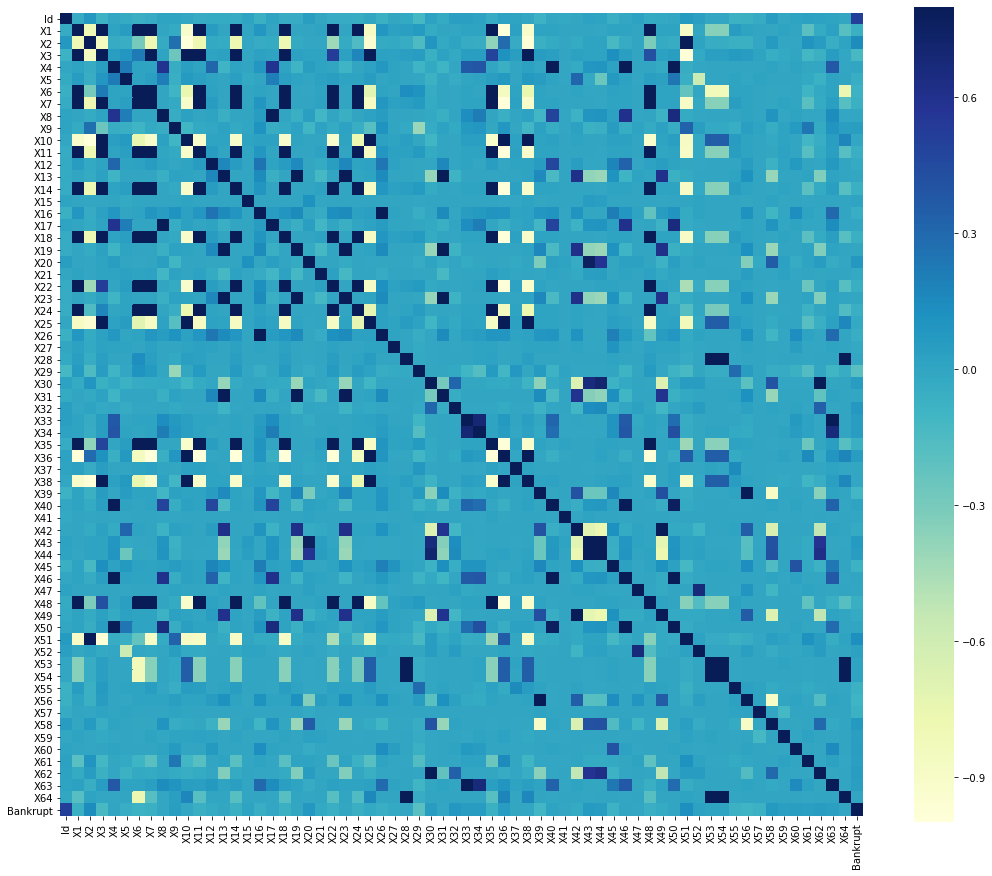

In [10]:
#correlation matrix
corrmat = data.corr()
f, ax = plt.subplots(figsize=(18, 15))
sns.heatmap(corrmat, vmax=.8, square=True,cmap="YlGnBu");

From the heatmap, which describe the correlation of different var in the training set, we find that some of the variables are highly correlated with each other such as (X6, X7), (X33, X34), (X43, X44), (X53, X54)

Moreover, when we look at the Bankrupt, we find that none of the variable have strong correlate with Bankrupt

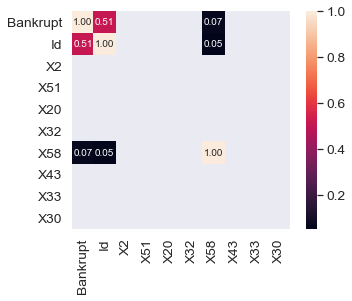

In [11]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'Bankrupt')['Bankrupt'].index
cm = np.corrcoef(data[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

We can find from the heat map and the corr matrix that not so many factor have a strong relationship with bankrupt directly

## Clean Data

In [12]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data

,Total,Percent
X37,1776,0.435721
X59,1776,0.435721
X6,1575,0.386408
X27,585,0.143523
X22,387,0.094946
X42,384,0.094210
X45,225,0.055201
X47,219,0.053729
X20,198,0.048577
X60,198,0.048577


We see that X37 X59 X6 X27 have more than 10% missing value so that we need to delete them

In [13]:
missing_data[missing_data['Percent'] > 0.1].index

Index(['X37', 'X59', 'X6', 'X27'], dtype='object')

In [14]:
drop_list = ['X37', 'X59', 'X6', 'X27']

In [15]:
#Clean data: delete data that have so much nan
#Para threshold: the precentage of nan in the column it should be delete
from sklearn.base import BaseEstimator, TransformerMixin

class MissingDataDeler(BaseEstimator, TransformerMixin):
    def __init__(self, threshold = 0.05):
        """
        :threshold -> int
        """
        self.threshold = threshold
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        data_missing = X.drop(drop_list, axis=1)
        return data_missing

In [16]:
# Fill the missing data with different ways
# 
from sklearn.base import BaseEstimator, TransformerMixin

class MissingDataFillerOne(BaseEstimator, TransformerMixin):
    def __init__(self, fill_way = 'uniform'):
        """
        : fill_way -> str
        it could be median, mean, uniform, normal
        """
        self.fill_way = fill_way
        
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        for index in X.columns:
            column_mean = X[index].mean()
            column_std = X[index].std()
            column_median = X[index].median()
            column_numna = X[index].isnull().sum()
            if self.fill_way == 'mean':
                column_fill = np.full(column_numna, column_mean)
            elif self.fill_way == 'median':
                column_fill = np.full(column_numna, column_median)
            elif self.fill_way == 'uniform':
                column_fill = np.random.uniform(column_mean - column_std, column_mean + column_std , size=column_numna)
            elif self.fill_way == 'normal':
                column_fill = np.random.normal(column_mean, column_std, size=column_numna)
            X.loc[X[index].isnull(),index] = column_fill
        return X


## Feature Engineering

In [17]:
# Get the train and test data
x_all = data.drop(['Id','Bankrupt'], axis=1)
y_all = data['Bankrupt'].copy()
num_test = 0.2
X_train, X_test, y_train, y_test = train_test_split(x_all, y_all,test_size=num_test, random_state=42)

In [18]:
# oversampling
from imblearn.over_sampling import SMOTE, ADASYN 
smt = SMOTE()

In [19]:
# Scaling: standardization
from sklearn.preprocessing import StandardScaler
std_scaler = StandardScaler()

We find that the pipeline could  not support oversample by SMOTE and it would be a little bit confuse to use SMOTE between two pipeline so we would give up using oversampling to deal with the imbalance data.

However, in the model, we could set the weight of different class different to deal with the imbalance data. Here we do so.

## Model Training

- Since it is a classification problem with imbalance data, it is easy for us to think about using logistic regression and tree model to deal with it. Thus, we choose to use logistic regression and xgboost.

- Note that logistic regression with L1 penalty could have the function of feature selection

- Note that xgboost is a kind of Gradient Boosting Tree




We frist just using the naive logistic regression and naive xbg

In [20]:
xgboost = xgb.XGBClassifier()
logistic = linear_model.LogisticRegression()

In [21]:
pipe = Pipeline(steps=[('MissingDataDeler', MissingDataDeler(0.1)), ('MissingFill', MissingDataFillerOne('uniform')), 
                      ('logistic', logistic)])
pipe2 = Pipeline(steps=[('MissingDataDeler', MissingDataDeler(0.1)), ('MissingFill', MissingDataFillerOne('uniform')), 
                      ('xgb', xgboost)])

pipe.fit(X_train, y_train)
y_predict = pipe.predict(X_test)
print('Logistic: \n')
print(classification_report(y_test, y_predict))

Logistic: 

              precision    recall  f1-score   support

           0       0.92      0.96      0.94       743
           1       0.32      0.18      0.23        73

    accuracy                           0.89       816
   macro avg       0.62      0.57      0.59       816
weighted avg       0.87      0.89      0.88       816



In [22]:
pipe2.fit(X_train, y_train)
y_predict = pipe2.predict(X_test)
print('XGB: \n')
print(classification_report(y_test, y_predict))

XGB: 

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       743
           1       0.78      0.44      0.56        73

    accuracy                           0.94       816
   macro avg       0.86      0.71      0.76       816
weighted avg       0.93      0.94      0.93       816



## Imbalanced Data

We use the parameter 'class_weight' to give different weight to different class of sample to deal with the imbalanced data

In [23]:
# Get the wight ratio, i.e. the ratio of imbalance
weight_ratio = float(len(y_train[y_train == 0]))/float(len(y_train[y_train == 
1]))
weight_ratio

8.673590504451038

In [24]:
# the model
xgboost = xgb.XGBClassifier(scale_pos_weight=weight_ratio)
logistic = linear_model.LogisticRegression(class_weight={1:weight_ratio, 0:1}, penalty='l1') 

pipe = Pipeline(steps=[('MissingDataDeler', MissingDataDeler(0.1)), ('MissingFill', MissingDataFillerOne('uniform')), 
                      ('logistic', logistic)])
pipe2 = Pipeline(steps=[('MissingDataDeler', MissingDataDeler(0.1)), ('MissingFill', MissingDataFillerOne('uniform')), 
                      ('xgb', xgboost)])

In [25]:
# predict
pipe.fit(X_train, y_train)
y_predict = pipe.predict(X_test)
print('Logistic: \n')
print(classification_report(y_test, y_predict))

Logistic: 

              precision    recall  f1-score   support

           0       0.97      0.81      0.88       743
           1       0.27      0.71      0.40        73

    accuracy                           0.81       816
   macro avg       0.62      0.76      0.64       816
weighted avg       0.90      0.81      0.84       816



In [26]:
pipe2.fit(X_train, y_train)
y_predict = pipe2.predict(X_test)
print('XGB: \n')
print(classification_report(y_test, y_predict))

XGB: 

              precision    recall  f1-score   support

           0       0.98      0.91      0.94       743
           1       0.45      0.77      0.57        73

    accuracy                           0.90       816
   macro avg       0.71      0.84      0.75       816
weighted avg       0.93      0.90      0.91       816



##  Different importance of each type of misclassification

- In logistic regression, we can still use the changing of weight to change the threshold and get the result
- In XBG, we try to define our log cost function and the math formula of gaining the grad and hass will not be shown here and you can refer to https://medium.com/datadriveninvestor/understanding-the-log-loss-function-of-xgboost-8842e99d975d, In this case, we multiple a beta as the importance in front of the term "y*ln(y)"

In [27]:
# xgb obj
def customObj1(predict, real):
    p = real
    y = predict
    beta = 5
    #grad = p * (beta + y - beta*y) - y
    grad = p * (beta*y + 1 - y) - beta * y
    #hess = p * (1 - p) * (beta + y - beta*y)
    hess =  p * (1 - p) * (beta*y + 1 - y)
    return grad, hess

xgboost = xgb.XGBClassifier(scale_pos_weight=weight_ratio, objective=customObj1)
logistic = linear_model.LogisticRegression(class_weight={1:weight_ratio*5, 0:1}, penalty='l1')

pipe = Pipeline(steps=[('MissingDataDeler', MissingDataDeler(0.1)), ('MissingFill', MissingDataFillerOne('uniform')), 
                      ('logistic', logistic)])
pipe2 = Pipeline(steps=[('MissingDataDeler', MissingDataDeler(0.1)), ('MissingFill', MissingDataFillerOne('uniform')), 
                      ('xgb', xgboost)])

In [28]:
# predict
pipe.fit(X_train, y_train)
y_predict = pipe.predict(X_test)
print('Logistic: \n')
print(classification_report(y_test, y_predict))

Logistic: 

              precision    recall  f1-score   support

           0       0.98      0.31      0.47       743
           1       0.12      0.95      0.21        73

    accuracy                           0.37       816
   macro avg       0.55      0.63      0.34       816
weighted avg       0.91      0.37      0.45       816



In [29]:
pipe2.fit(X_train, y_train)
y_predict = pipe2.predict(X_test)
print('XGB: \n')
print(classification_report(y_test, y_predict))

XGB: 

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       743
           1       0.50      0.66      0.57        73

    accuracy                           0.91       816
   macro avg       0.73      0.80      0.76       816
weighted avg       0.92      0.91      0.92       816



## Fine Tune
Here we fine tune the model and add standaralization

In [30]:
# xgb weight
weight_ratio = float(len(y_train[y_train == 0]))/float(len(y_train[y_train == 
1]))
#w_array = np.array([1.0]*y_train.shape[0])
#w_array[y_train==1] = weight_ratio *5
#w_array[y_train==0] = 1

# xgb obj
def customObj1(predict, real):
    p = real
    y = predict
    beta = 450
    #grad = p * (beta + y - beta*y) - y
    grad = p * (beta*y + 1 - y) - beta * y
    #hess = p * (1 - p) * (beta + y - beta*y)
    hess =  p * (1 - p) * (beta*y + 1 - y)
    return grad, hess

In [31]:
# fit the model
xgboost = xgb.XGBClassifier(max_depth=6,n_estimators=300,learning_rate=0.05,  scale_pos_weight=weight_ratio*5, 
                            objective=customObj1, max_delta_step=1)
logistic = linear_model.LogisticRegression(class_weight={1:5*weight_ratio, 0:1}, penalty='l1')

In [32]:
pipe = Pipeline(steps=[('MissingDataDeler', MissingDataDeler(0.1)), ('MissingFill', MissingDataFillerOne('uniform')),
                        ('scaler', std_scaler), ('logistic', logistic)])
pipe2 = Pipeline(steps=[('MissingDataDeler', MissingDataDeler(0.06)), ('MissingFill', MissingDataFillerOne('uniform')),
                       ('scaler', std_scaler), ('xgb', xgboost)])

In [33]:
pipe.fit(X_train, y_train)
y_predict = pipe.predict(X_test)
print('Logistic \n')
print(classification_report(y_test, y_predict))

Logistic 

              precision    recall  f1-score   support

           0       1.00      0.27      0.43       743
           1       0.12      0.99      0.21        73

    accuracy                           0.34       816
   macro avg       0.56      0.63      0.32       816
weighted avg       0.92      0.34      0.41       816



In [34]:
pipe2.fit(X_train, y_train)
y_predict = pipe2.predict(X_test)  
print('XGB \n')
print(classification_report(y_test, y_predict))

XGB 

              precision    recall  f1-score   support

           0       0.98      0.88      0.93       743
           1       0.40      0.78      0.53        73

    accuracy                           0.87       816
   macro avg       0.69      0.83      0.73       816
weighted avg       0.92      0.87      0.89       816



### Try hard to deal with XGB
we custom define a eval metric for xgboost

But very upset, the result is not imporved

In [35]:

from sklearn.metrics import confusion_matrix
def customedscore(preds, real):
    #pred = [int(i>=0.5) for i in preds]
    confusion_matrixs = confusion_matrix(real, pred)
    recall =float(confusion_matrixs[0][0]) / float(confusion_matrixs[0][1]+confusion_matrixs[0][0])
    precision = float(confusion_matrixs[0][0]) / float(confusion_matrixs[1][0]+confusion_matrixs[0][0])
    beta = 10
    F = (1+beta*beta) * (precision* recall) / ((beta*beta)*precision + recall)
    #F = 5*precision* recall/(1*precision+3*recall)*100
    return 'FSCORE',float(F)

In [36]:
xgboost = xgb.XGBClassifier(max_depth=6,n_estimators=300,learning_rate=0.05,  scale_pos_weight=weight_ratio*5, 
                            objective=customObj1, max_delta_step=1, feval = customedscore)
pipe2 = Pipeline(steps=[('MissingDataDeler', MissingDataDeler(0.06)), ('MissingFill', MissingDataFillerOne('uniform')),
                       ('scaler', std_scaler), ('xgb', xgboost)])

In [37]:
pipe2.fit(X_train, y_train)
y_predict = pipe2.predict(X_test)  
print('XGB \n')
print(classification_report(y_test, y_predict))

XGB 

              precision    recall  f1-score   support

           0       0.98      0.87      0.92       743
           1       0.38      0.79      0.52        73

    accuracy                           0.87       816
   macro avg       0.68      0.83      0.72       816
weighted avg       0.92      0.87      0.89       816



## Comment
- We can see that the logistic moedl have a high recall (98%) of bankrupt companies and we want this feature in predicting though the accuracy rate is only around 35%

- The xgb model have a recall on bankrupt about 80% and accuracy about 87%. Maybe we can try to fine tune again to enhance the recall performance of xgb since I could have a good balance between accuracy and recall

- Above all, we choose the logistic model as the final model

## The final result
Here present the final function

In [38]:
TEST_PATH = "./data"

import pandas as pd
import os

testFileName = os.path.join(TEST_PATH, "test.csv")

def MyModel(fileName=None):
    print("Test file: ", fileName)
    
    # It should create an array of predictions; we initialize it to the empty array for convenience
    predictions = []
    data_test = pd.read_csv(testFileName)
    data_test = CleanOne(data_test)
    X_test = data_test.drop(['Id'], axis=1)
    
    # YOUR CODE GOES HERE
    DATA_PATH = "./data"
    data = pd.read_csv( os.path.join(DATA_PATH, "bankruptcy_data.csv") )
    data = CleanOne(data)
    X_train = data.drop(['Id','Bankrupt'], axis=1)
    y_train = data['Bankrupt'].copy()
    logistic = linear_model.LogisticRegression(class_weight={1:5*weight_ratio, 0:1}, penalty='l1')
    pipe = Pipeline(steps=[ ('MissingDataDeler', MissingDataDeler(0.1)), ('MissingFill', MissingDataFillerOne('uniform')),
                        ('scaler', std_scaler), ('logistic', logistic)])
    pipe.fit(X_train, y_train)
    predictions = pipe.predict(X_test)
    return predictions

predicts = MyModel(fileName=testFileName)

Test file:  ./data/midterm_project\test.csv


In [39]:
testFileName = os.path.join(TEST_PATH, "test.csv")
print(testFileName)
df = pd.read_csv(testFileName)

./data/midterm_project\test.csv


In [40]:
print('Done')

Done
